# Object Detection

In this notebook, we will go through basics of Object Detection and implement SSD (**to be implemented**).

Here we will use [fastai](https://github.com/fastai/course-v3  "Fastai Tutorial").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/object/detection/2019/01/07/Mystery-of-Object-Detection/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/Object%20Detection/Fastai/object_detection_fastai.ipynb)

## Data preprocessing

We will be looking at the [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/). It's quite slow, so you may prefer to download from this [mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this)

In [0]:
!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
#!wget https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
!tar xf VOCtrainval_06-Nov-2007.tar
#!tar xf VOCtest_06-Nov-2007.tar

--2019-02-04 14:07:11--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  23.2MB/s    in 20s     

2019-02-04 14:07:37 (22.1 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



As well as the images, there are also annotations - bounding boxes showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from this [link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

In [0]:
! wget 'https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip'
! unzip 'PASCAL_VOC.zip'

--2019-02-04 14:07:44--  https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1998182 (1.9M) [application/zip]
Saving to: ‘PASCAL_VOC.zip’

PASCAL_VOC.zip      100%[===================>]   1.91M  --.-KB/s    in 0.03s   

2019-02-04 14:07:44 (69.3 MB/s) - ‘PASCAL_VOC.zip’ saved [1998182/1998182]

Archive:  PASCAL_VOC.zip
   creating: PASCAL_VOC/
  inflating: PASCAL_VOC/pascal_test2007.json  
  inflating: PASCAL_VOC/pascal_train2007.json  
  inflating: PASCAL_VOC/pascal_train2012.json  
  inflating: PASCAL_VOC/pascal_val2007.json  
  inflating: PASCAL_VOC/pascal_val2012.json  


## Multilabel classification preprocessing

In [0]:
from pathlib import Path
import pandas as pd
import numpy as np
import collections
import json
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

%matplotlib inline

IMG_PATH = Path('VOCdevkit/VOC2007/JPEGImages')

In [0]:
path = Path('PASCAL_VOC')
trn = json.load((path/'pascal_train2007.json').open())
trn.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [0]:
img, anno, cat = ['images', 'annotations', 'categories']
trn[img][:3], trn[anno][:3], trn[cat][:3]

([{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
  {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
  {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334}],
 [{'area': 34104,
   'bbox': [155, 96, 196, 174],
   'category_id': 7,
   'id': 1,
   'ignore': 0,
   'image_id': 12,
   'iscrowd': 0,
   'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
  {'area': 13110,
   'bbox': [184, 61, 95, 138],
   'category_id': 15,
   'id': 2,
   'ignore': 0,
   'image_id': 17,
   'iscrowd': 0,
   'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]},
  {'area': 81326,
   'bbox': [89, 77, 314, 259],
   'category_id': 13,
   'id': 3,
   'ignore': 0,
   'image_id': 17,
   'iscrowd': 0,
   'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]]}],
 [{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
  {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
  {'id': 3, 'name': 'bird', 'supercategory': 'none'}])

In [0]:
file_name, ID, img_id, cat_id, bbox = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn[cat])
trn_fns = dict((o[ID], o[file_name]) for o in trn[img])
trn_ids = [o[ID] for o in trn[img]]

In [0]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn[anno]:
        if not o['ignore']:
            bb = o[bbox]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[img_id]].append((bb,o[cat_id]))
    return trn_anno

trn_anno = get_trn_anno()

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [0]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = Image.open(IMG_PATH/trn_fns[i])
    print (im.size)
    draw_im(im, im_a)

(500, 281)


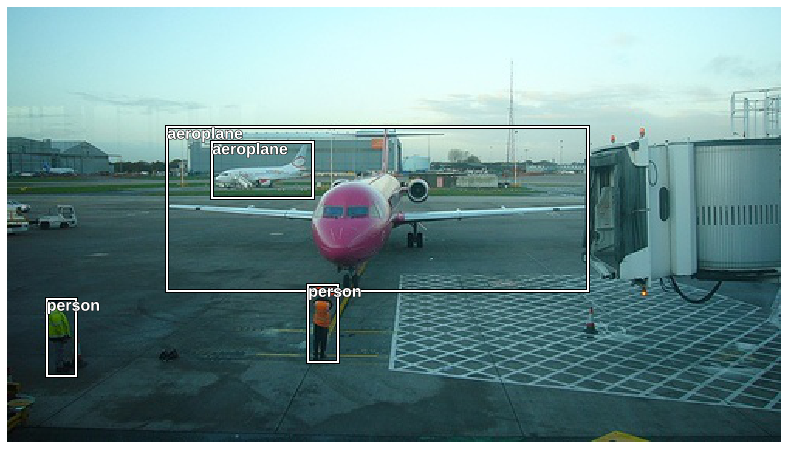

In [0]:
draw_idx(32)

(500, 366)


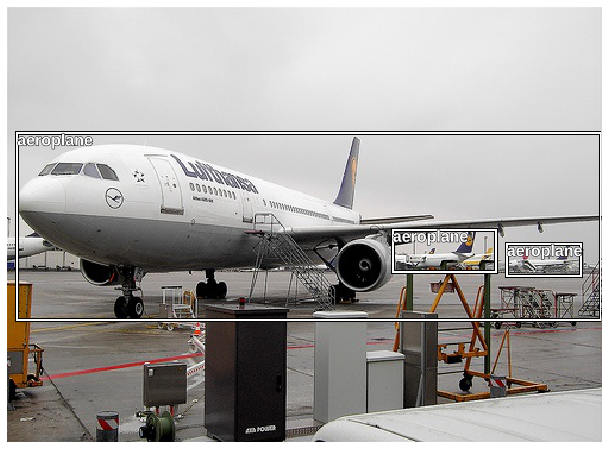

In [0]:
draw_idx(33)

(500, 335)


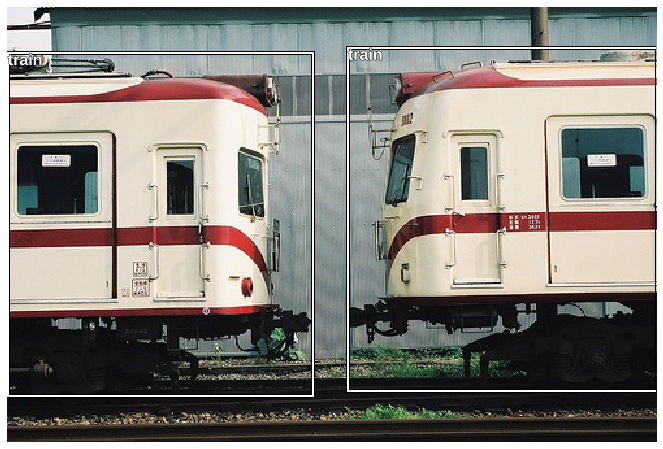

In [0]:
draw_idx(42)

(332, 500)


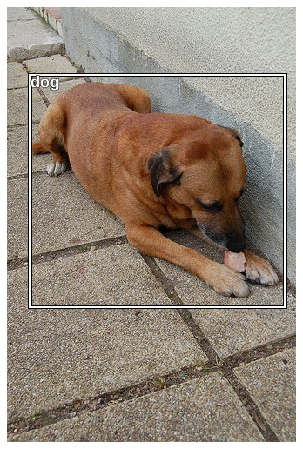

In [0]:
draw_idx(36)

In [0]:
mc = [set([p[1] for p in trn_anno[o]]) for o in trn_ids]

In [0]:
labels = []
for i in range(len(mc)):
  l = " "
  for c in mc[:][i]:
      l = l + "".join(cats[c])
      l = l + " "
  labels.append(l)

In [0]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'class': [l for l in labels]}, columns=['fn','class'])
df.to_csv('pascal_voc2007_train_classes.csv', index=False)

In [0]:
display(df.head())
print (df.shape)

,fn,class
0,000012.jpg,car
1,000017.jpg,horse person
2,000023.jpg,bicycle person
3,000026.jpg,car
4,000032.jpg,aeroplane person


(2501, 2)


## Multi-label classification

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np
from pathlib import Path

path = Path("/content/")

In [0]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)

src = (ImageItemList.from_csv(path, 'pascal_voc2007_train_classes.csv', folder='VOCdevkit/VOC2007/JPEGImages')
        .random_split_by_pct(0.1)
        .label_from_df(label_delim=' '))

data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))  

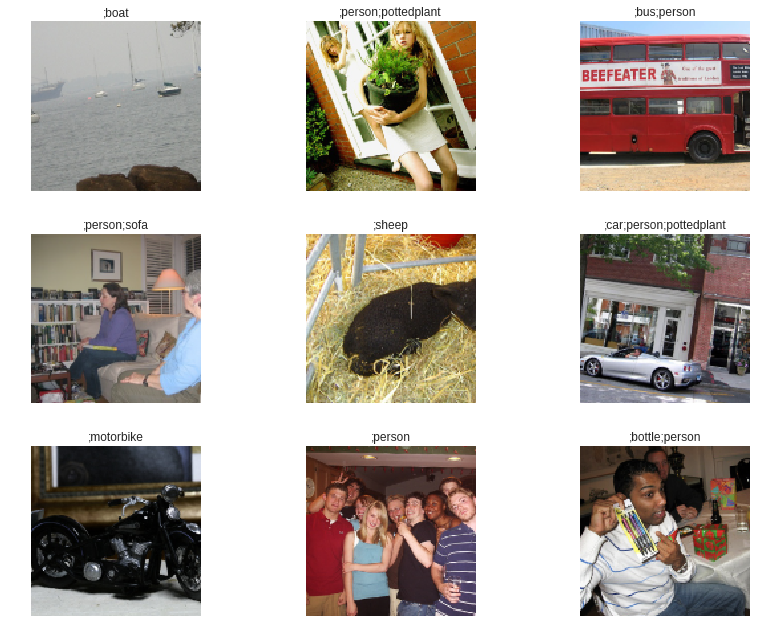

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.4)
learn = create_cnn(data, arch, metrics=acc_02)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 27263632.97it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


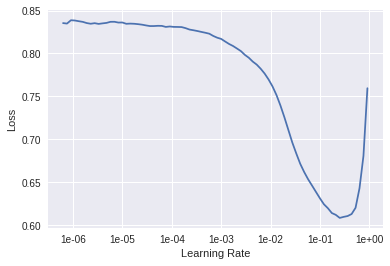

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 0.01/2
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh
1,0.589060,0.193001,0.948000
2,0.279398,0.102544,0.965333
3,0.175434,0.098976,0.966095


In [0]:
learn.save('stage-1-rn50')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


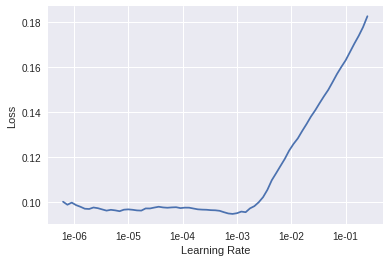

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh
1,0.095680,0.091266,0.969333
2,0.083792,0.084383,0.971238
3,0.068210,0.083273,0.970095


In [0]:
learn.save('stage-2-rn50')

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


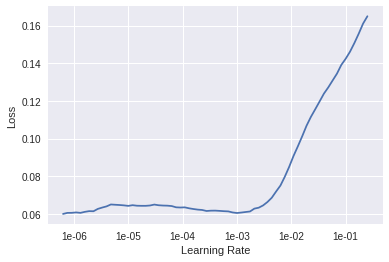

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2/2
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh
1,0.071416,0.147935,0.954095
2,0.081976,0.083486,0.972190
3,0.067042,0.078240,0.974286


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh
1,0.047083,0.074859,0.976952
2,0.039438,0.075205,0.976000
3,0.032025,0.070614,0.977143


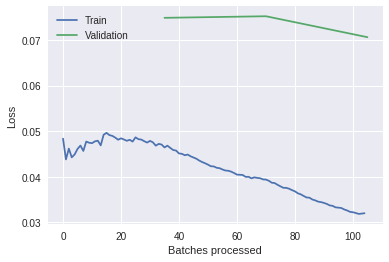

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

(MultiCategory ;cat, tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]), tensor([1.0000e+00, 2.3597e-04, 5.0844e-04, 2.5020e-04, 3.9421e-04, 1.7941e-03,
        2.1228e-04, 5.7526e-03, 9.9127e-01, 1.5780e-02, 1.1632e-03, 1.5739e-03,
        4.0067e-02, 1.6230e-03, 7.4185e-04, 7.5155e-04, 1.8638e-03, 8.0438e-04,
        1.8697e-03, 9.0022e-05, 1.2655e-03]))


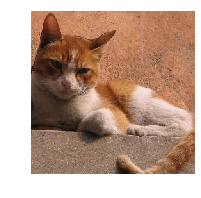

In [0]:
num = np.random.randint(low=0, high=len(data.valid_ds))
img = data.valid_ds[num][0]
print (learn.predict(img, thresh=0.4))
img.show()

(MultiCategory ;bicycle;person, tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0.]), tensor([1.0000e+00, 3.4144e-04, 7.3096e-01, 2.1760e-03, 3.3537e-03, 8.9224e-04,
        1.5264e-03, 4.8265e-03, 4.9933e-05, 2.5589e-03, 3.3183e-03, 3.3346e-03,
        2.8177e-03, 4.1444e-02, 1.8498e-03, 9.9982e-01, 2.3452e-03, 4.7940e-04,
        7.2970e-04, 6.5580e-05, 4.6289e-04]))


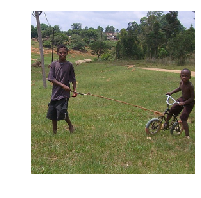

In [0]:
num = np.random.randint(low=0, high=len(data.valid_ds))
img = data.valid_ds[num][0]
print (learn.predict(img, thresh=0.4))
img.show()

(MultiCategory ;bus;person, tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0.]), tensor([9.9999e-01, 1.3674e-03, 2.8977e-03, 2.1927e-03, 9.0023e-03, 8.1196e-03,
        9.8887e-01, 1.9287e-01, 2.8310e-03, 5.3945e-03, 6.3229e-04, 8.6509e-04,
        7.1118e-03, 8.4056e-03, 1.8254e-02, 8.2204e-01, 6.8366e-03, 9.0145e-04,
        2.8485e-03, 7.3263e-03, 2.6273e-03]))


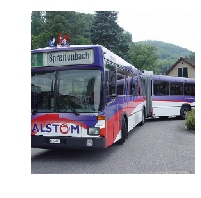

In [0]:
num = np.random.randint(low=0, high=len(data.valid_ds))
img = data.valid_ds[num][0]
print (learn.predict(img, thresh=0.4))
img.show()

## SSD